In [15]:
from IPython import get_ipython

import time
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
sns.set(style = "darkgrid")
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import statsmodels.api as sm
from sklearn import preprocessing 
import ema_workbench.em_framework.evaluators


import os
from dest_directories import gz_path, fig_path
from dicemodel.specs import change_fontsize
from dicemodel.noDICE_v7 import PyDICE
model_version = 'v7'

from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, CategoricalParameter, TimeSeriesOutcome, ScalarOutcome, ArrayOutcome, Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
from ema_workbench import save_results, load_results
from ema_workbench.analysis import prim, cart
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis import plotting, plotting_util, pairs_plotting, parcoords

ema_logging.log_to_stderr(ema_logging.INFO)

model = PyDICE()
dice_sm = Model('dicesmEMA', function=model)

In [2]:


dice_sm.uncertainties = [
    RealParameter('tfp_gr',  0.07, 0.09),
    RealParameter('sigma_gr', -0.012, -0.008),
    RealParameter('pop_gr', 0.1, 0.15),
    RealParameter('fosslim',  4000.0, 13649),
    IntegerParameter('cback', 100, 600),
     RealParameter('emdd', 1.0, 0.99),
    IntegerParameter('vd_switch', 0, 1),
    ]
# dice_sm.constants = [
#     Constant('emdd', 0.55),
#     Constant('vd_switch', 1)
#     ]
    
dice_sm.levers = [
    RealParameter('sr', 0.1, 0.5),
    RealParameter('prtp_con',  0.001, 0.015),
    RealParameter('emuc', 1.01, 2.00),
    IntegerParameter('periodfullpart', 10, 58),
    IntegerParameter('miu_period', 10, 58)
                 ]

dice_sm.outcomes = [
    TimeSeriesOutcome('Atmospheric Temperature'),
    TimeSeriesOutcome('Total Output'),
    TimeSeriesOutcome('Per Capita Consumption'),
    TimeSeriesOutcome('Consumption Growth'),
    TimeSeriesOutcome('Utility of Consumption'),
    TimeSeriesOutcome('Per Capita Damage'),
    TimeSeriesOutcome('Damage Growth'),
    TimeSeriesOutcome('Disutility of Damage'),
    TimeSeriesOutcome('Welfare'),
    # TimeSeriesOutcome('Undiscounted Period Welfare'),
    TimeSeriesOutcome('Consumption SDR'),
    TimeSeriesOutcome('Damage SDR'),
    TimeSeriesOutcome('SCC')
                    ]
# dice_sm.outcomes = [
#             ScalarOutcome('Atmospheric Temperature 2300', kind=ScalarOutcome.MINIMIZE),
#             ScalarOutcome('Total Output 2300', kind=ScalarOutcome.MAXIMIZE),
#             # ScalarOutcome('Per Capita Consumption 2300', kind=ScalarOutcome.INFO),
#             # ScalarOutcome('Consumption Growth 2300', kind=ScalarOutcome.INFO),
#             ScalarOutcome('Utility of Consumption 2300', kind=ScalarOutcome.MAXIMIZE),
#             # ScalarOutcome('Per Capita Damage 2300', kind=ScalarOutcome.INFO),
#             # ScalarOutcome('Damage Growth 2300', kind=ScalarOutcome.INFO),
#             ScalarOutcome('Disutility of Damage 2300', kind=ScalarOutcome.MINIMIZE),
#             ScalarOutcome('Welfare 2300', kind=ScalarOutcome.MAXIMIZE),
#             # ScalarOutcome('Undiscounted Period Welfare 2300', kind=ScalarOutcome.INFO),
#             ScalarOutcome('Consumption SDR 2300', kind=ScalarOutcome.INFO),
#             ScalarOutcome('Damage SDR 2300', kind=ScalarOutcome.INFO)
            # ]



In [3]:
dice_opt = pd.read_excel("DICE2013R.xlsm" ,sheet_name = "Opttax", index_col = 0)

In [4]:
from dicemodel.specs import nordhaus_policy, reference_scenario, change_fontsize

nord_optimal_policy = Policy('nord_optimal_policy', **nordhaus_policy(np.mean(dice_opt.iloc[129]),prtp_con =0.015,emuc=1.45, miu_period= 29, periodfullpart=29 )) # ,vd_switch=1  
nord_optimal_policy

Policy({'sr': 0.24868248835166676, 'prtp con': 0.015, 'emuc': 1.45, 'periodfullpart': 29, 'miu_period': 29})

In [5]:
n_scenarios = 100000
run = 'run_42_NordOE_'

# 32: OE with corrected emdd range
# ...
# 40: Nord OE with SCC correctly initialized
# 41: Nord OE no run changes, re-saving model changes and repeating run because init SCC remains negative in run 40
# 42: vd_switch and EMDD removed from mdoel constants to uncertainties

In [6]:
results = load_results(os.path.join(gz_path,'run_42_NordOE_100000s_.tar.gz'))
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from E:\Year_2_Quarter_4\Thesis\06_Code\results\gz_files\run_42_NordOE_100000s_.tar.gz


In [33]:
cleaned_outcome = {}
for key, value in outcomes.items():
    cleaned_outcome[key] = value[:,2:-5]  
cleaned_outcome['Welfare'].shape

(100000, 58)

# pairs 1 = output, temp, damages, consumption, W
# pairs 2 = temp, U(C), V(D), W 
# pairs 3 = Con, con_g, sdr_con, U(C)
# pairs 4 = damages, sdr_dam, V(D) 
# time = temp, U(C), V(D), W, 
# time 2 = con, dam, sdr_con, sdr_dam

In [100]:
import copy

outcomes_shown = 'pairs_2'
cleaned_outcome_pairs_2 ={}
cleaned_outcome_pairs_2 = copy.deepcopy(cleaned_outcome)
# outcomes

In [101]:
# remove outcomes that you dont need for pairs plots and time series
rem_list = [
    # 'Atmospheric Temperature',
    'Total Output',
    'Per Capita Consumption',
    'Consumption Growth',
    # 'Utility of Consumption',
    'Per Capita Damage',
    'Damage Growth',
    # 'Disutility of Damage',
    # 'Welfare',
    'Consumption SDR',
    'Damage SDR',
    'SCC'
]
for key in rem_list:
    cleaned_outcome_pairs_2.pop(key)

In [102]:
cleaned_outcome_to_use = {}
cleaned_outcome_to_use = cleaned_outcome_pairs_2
cleaned_outcome_to_use.keys()

dict_keys(['Atmospheric Temperature', 'Utility of Consumption', 'Disutility of Damage', 'Welfare'])

In [103]:
cleaned_outcome_pairs_2.keys()

dict_keys(['Atmospheric Temperature', 'Utility of Consumption', 'Disutility of Damage', 'Welfare'])

In [104]:
# Values for 2300
end_outcome = {}
for key, value in cleaned_outcome_to_use.items():
    end_outcome[key] = value[:, -1] 

In [105]:

cleaned_outcomes_2050 = {}
for key, value in cleaned_outcome_to_use.items():
    cleaned_outcomes_2050[(key + '_2050')] = value[:,6]  

# cleaned_outcomes_2100 = {}
# for key, value in cleaned_outcome.items():
#     cleaned_outcomes_2100[(key + '_2100')] = value[:,16]  

cleaned_outcomes_2150 = {}
for key, value in cleaned_outcome_to_use.items():
    cleaned_outcomes_2150[(key + '_2150')] = value[:,26]  

# cleaned_outcomes_2200 = {}
# for key, value in cleaned_outcome.items():
#     cleaned_outcomes_2200[(key + '_2200')] = value[:,36]

# cleaned_outcomes_2250 = {}
# for key, value in cleaned_outcome.items():
#     cleaned_outcomes_2250[(key + '_2250')] = value[:,46]

cleaned_outcomes_2300 = {}
for key, value in cleaned_outcome_to_use.items():
    cleaned_outcomes_2300[(key + '_2300')] = value[:,56]

 # cleaned_outcomes_2150['Atmospheric Temperature_2150'].shape

cleaned_outcomes_milestones = {
    **cleaned_outcomes_2050, 
    # **cleaned_outcomes_2100, 
    **cleaned_outcomes_2150,
    # **cleaned_outcomes_2200, 
    # **cleaned_outcomes_2250, 
    **cleaned_outcomes_2300
    }

cleaned_outcomes_milestones.keys()


dict_keys(['Atmospheric Temperature_2050', 'Utility of Consumption_2050', 'Disutility of Damage_2050', 'Welfare_2050', 'Atmospheric Temperature_2150', 'Utility of Consumption_2150', 'Disutility of Damage_2150', 'Welfare_2150', 'Atmospheric Temperature_2300', 'Utility of Consumption_2300', 'Disutility of Damage_2300', 'Welfare_2300'])

In [ ]:
# repeat to compare with below, delete after
# sns.set(style = "darkgrid")
sns_plot = sns.pairplot(out_DF, hue='emdd', hue_order=['-1 to -0.5', '-0.5 to 0', '0 to 0.5', '0.5 to 0.99'], vars=list(end_outcome.keys())) # palette=clr_palette

# fig, ax = plt.pyplot.subplots()
# change_fontsize(fig, fs=20)
# fig.set_size_inches(20, 20)
sns_plot.savefig(os.path.join(fig_path, str(run) + '_snspairs_2_by_emdd' +'_x.png'))
plt.show()

Stat

In [178]:
out_DF = []

In [179]:
outDF = pd.DataFrame(cleaned_outcomes_milestones)
expDF = experiments

resDF = pd.concat([expDF,outDF], axis=1, join_axes=[expDF.index])

resDF['emdd'] = resDF['emdd'].apply(
    lambda x: '-1 to -0.5' if x < -0.5
        else('-0.5 to 0' if (x < 0)
            else('0 to 0.5' if (x < 0.5)
                else ('0.5 to 0.99')
                )
            )
    )


In [181]:
outDF = out_DF.sort_values([outDF.columns[-1]], ascending=1)

AttributeError: 'list' object has no attribute 'sort_values'

In [111]:
resDF.columns
# resDF['emdd']

Index(['cback', 'emdd', 'fosslim', 'pop_gr', 'sigma_gr', 'tfp_gr', 'vd_switch',
       'sr', 'emuc', 'periodfullpart', 'miu_period', 'scenario', 'policy',
       'model', 'prtp con', 'Atmospheric Temperature_2050',
       'Utility of Consumption_2050', 'Disutility of Damage_2050',
       'Welfare_2050', 'Atmospheric Temperature_2150',
       'Utility of Consumption_2150', 'Disutility of Damage_2150',
       'Welfare_2150', 'Atmospheric Temperature_2300',
       'Utility of Consumption_2300', 'Disutility of Damage_2300',
       'Welfare_2300'],
      dtype='object')

DISTPLOT

Boxplots

In [182]:
outDF.columns.values

array(['Atmospheric Temperature_2050', 'Utility of Consumption_2050',
       'Disutility of Damage_2050', 'Welfare_2050',
       'Atmospheric Temperature_2150', 'Utility of Consumption_2150',
       'Disutility of Damage_2150', 'Welfare_2150',
       'Atmospheric Temperature_2300', 'Utility of Consumption_2300',
       'Disutility of Damage_2300', 'Welfare_2300'], dtype=object)

In [183]:
# for i, outcome in enumerate(cleaned_outcome_to_use):
#     print (i, outcome)


In [198]:
resDF.iloc[:,15]

0        1.909442
1        1.920257
2        1.931770
3        1.923802
4        1.906253
5        1.923382
6        1.930270
7        1.922424
8        1.918990
9        1.927561
10       1.912692
11       1.899581
12       1.917075
13       1.923748
14       1.918694
15       1.938229
16       1.914015
17       1.909980
18       1.929730
19       1.923232
20       1.936150
21       1.930915
22       1.924713
23       1.905706
24       1.938555
25       1.912128
26       1.930732
27       1.914606
28       1.925802
29       1.940535
           ...   
99970    1.932132
99971    1.922109
99972    1.916414
99973    1.939402
99974    1.905357
99975    1.907265
99976    1.908662
99977    1.932037
99978    1.920845
99979    1.902184
99980    1.949325
99981    1.910613
99982    1.916198
99983    1.915297
99984    1.929007
99985    1.935569
99986    1.933445
99987    1.922583
99988    1.932794
99989    1.911107
99990    1.923920
99991    1.939550
99992    1.915781
99993    1.939637
99994    1

In [207]:
# sns.set(style = "darkgrid", font_scale=1.5)
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

# for i in range (2): 
#     for j in range (2): 
#         box_emddDF = pd.concat([resDF.iloc[:,15+(2*i+j)::4],resDF['emdd']], axis=1, join_axes = [resDF.index])
#         box_emddDF.columns = ['2050', '2150', '2300','emdd']    
    
#         box_emddDF = box_emddDF.melt(id_vars=['emdd'], var_name="Year" , value_name=outDF.columns.values[(2*i+j)][:-5])
#         box_emddDF = box_emddDF.sort_values([box_emddDF.columns[0]], ascending=True)

#         distbox = sns.boxenplot(x='Year', y=outDF.columns.values[(2*i+j)][:-5], data=box_emddDF, hue='emdd',hue_order=['-1 to -0.5', '-0.5 to 0', '0 to 0.5', '0.5 to 0.99'])


#         distbox.legend().remove()
# # handles, labels = distbox.get_legend_handles_labels()
# # distbox.legend(handles[:], labels, bbox_to_anchor=[0.3, 2.4], ncol = 4, fontsize=18)

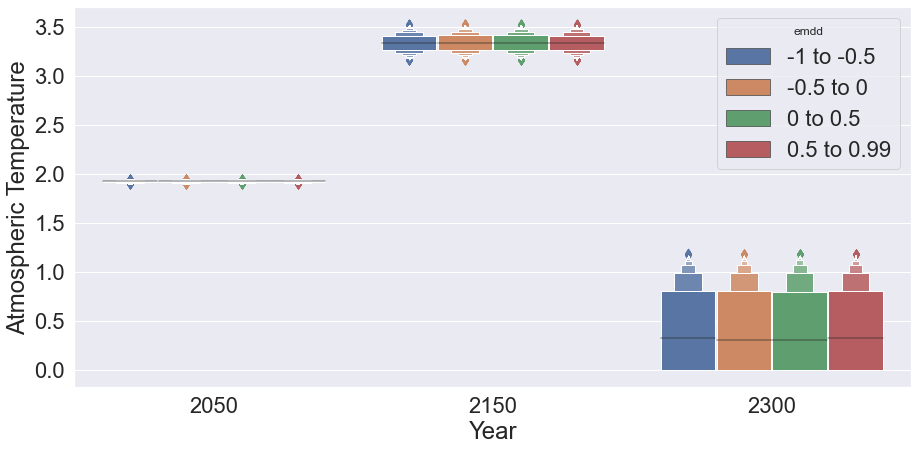

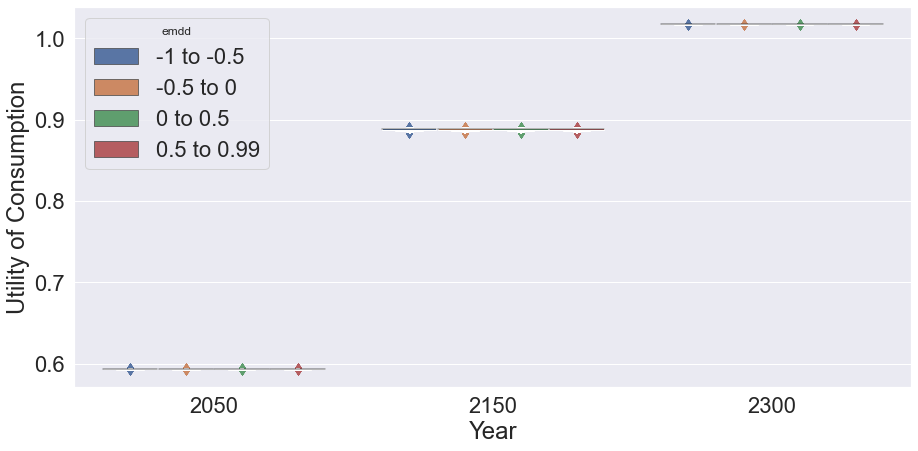

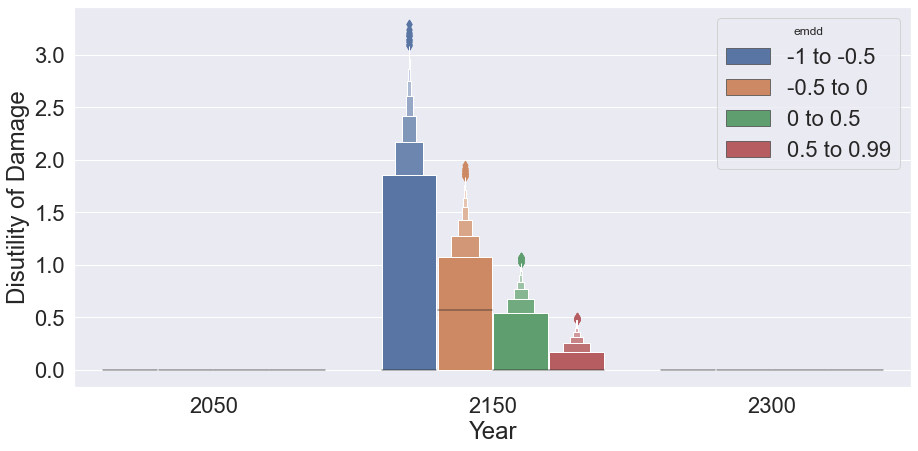

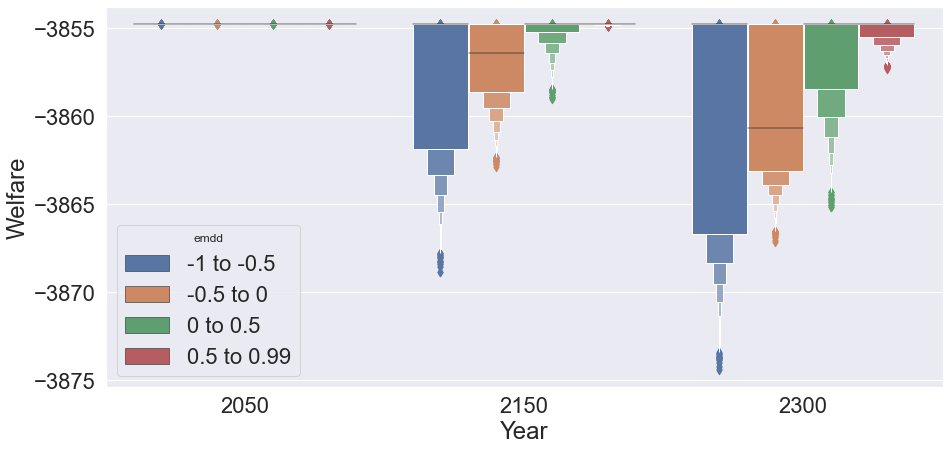

In [205]:
sns.set(style = "darkgrid", font_scale=2)
# for i in range(len(cleaned_outcome_to_use)):
for i, outcome in enumerate(cleaned_outcome_to_use): 

    # fig, axes = plt.subplots()

    # fig, axes = plotting.envelopes(experiments, cleaned_outcome,outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, legend=True)
      

    # fig.set_size_inches(25, 10)
    # # change_fontsize(fig, fs=20)

    # ax2, ay2 = axes
    box_emddDF = pd.concat([resDF.iloc[:,15+i::4],resDF['emdd']], axis=1, join_axes = [resDF.index])
    box_emddDF.columns = ['2050', '2150', '2300','emdd']    
    box_emddDF = box_emddDF.melt(id_vars=['emdd'], var_name="Year" , value_name=outDF.columns.values[i][:-5])
    box_emddDF = box_emddDF.sort_values([box_emddDF.columns[0]], ascending=True)
    plt.figure(figsize=(15, 7))

    distbox = sns.boxenplot(x='Year', y=outDF.columns.values[i][:-5], data=box_emddDF, hue='emdd',hue_order=['-1 to -0.5', '-0.5 to 0', '0 to 0.5', '0.5 to 0.99']) # ax=ax2, ay=ay2
    # distbox.legend(fontsize=25)
    #distbox.axes.set_xticklabels(labels=box_damageDF["variable"].unique(), rotation=45)
    # distbox.axes.grid(alpha=0.5)

distbox.figure.savefig(os.path.join(fig_path,  str(run) + '_BOXENPLOT_' + outDF.columns.values[i][:-5] +'.png')) 

    
    

Describe the statistical results of the model outcome

In [142]:
lowest_emdd_DF = resDF[resDF['emdd'] == "-1 to -0.5"].iloc[:,15:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
column_lowest_emdd = []
for _ in lowest_emdd_DF.columns.values:
    column_lowest_emdd.append(_+'_Very Low EMDD')
lowest_emdd_DF.columns = column_lowest_emdd

low_emdd_DF = resDF[resDF['emdd'] == '-0.5 to 0'].iloc[:,15:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
column_low_emdd = []
for _ in low_emdd_DF.columns.values:
    column_low_emdd.append(_+'_Low EMDD')
low_emdd_DF.columns = column_low_emdd

high_emdd_DF = resDF[resDF['emdd'] == '0 to 0.5'].iloc[:,15:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
column_high_emdd = []
for _ in high_emdd_DF.columns.values:
    column_high_emdd.append(_+'_High EMDD')
high_emdd_DF.columns = column_high_emdd

highest_emdd_DF = resDF[resDF['emdd'] == '0.5 to 0.99'].iloc[:,15:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
column_highest_emdd = []
for _ in highest_emdd_DF.columns.values:
    column_highest_emdd.append(_+'_Very High EMDD')
highest_emdd_DF.columns = column_highest_emdd

In [143]:
dist_describeDF = pd.concat([lowest_emdd_DF, low_emdd_DF, high_emdd_DF, highest_emdd_DF], axis = 1, join_axes = [lowest_emdd_DF.index])

In [144]:
dist_describeDF = dist_describeDF.sort_index(axis=1)

In [145]:
dist_describeDF

,Atmospheric Temperature_2050_High EMDD,Atmospheric Temperature_2050_Low EMDD,Atmospheric Temperature_2050_Very High EMDD,Atmospheric Temperature_2050_Very Low EMDD,Atmospheric Temperature_2150_High EMDD,Atmospheric Temperature_2150_Low EMDD,Atmospheric Temperature_2150_Very High EMDD,Atmospheric Temperature_2150_Very Low EMDD,Atmospheric Temperature_2300_High EMDD,Atmospheric Temperature_2300_Low EMDD,...,Welfare_2050_Very High EMDD,Welfare_2050_Very Low EMDD,Welfare_2150_High EMDD,Welfare_2150_Low EMDD,Welfare_2150_Very High EMDD,Welfare_2150_Very Low EMDD,Welfare_2300_High EMDD,Welfare_2300_Low EMDD,Welfare_2300_Very High EMDD,Welfare_2300_Very Low EMDD
count,25125.000000,25125.000000,24624.000000,25126.000000,25125.000000,25125.000000,24624.000000,25126.000000,25125.000000,25125.000000,...,24624.000000,25126.000000,25125.000000,25125.000000,24624.000000,25126.000000,25125.000000,25125.000000,24624.000000,25126.000000
mean,1.922233,1.922158,1.922127,1.922027,3.337804,3.337211,3.336812,3.336278,0.407308,0.409713,...,-3854.772335,-3854.772353,-3855.132931,-3856.758975,-3854.780566,-3858.396501,-3856.805881,-3858.972093,-3855.176307,-3860.833469
std,0.011785,0.011912,0.011816,0.011786,0.086847,0.087390,0.086948,0.086614,0.412058,0.412911,...,0.002603,0.002587,0.636692,2.169787,0.019053,3.894355,2.404844,4.265573,0.559832,6.270972
min,1.894374,1.894606,1.894584,1.894491,3.154888,3.156350,3.156556,3.155434,0.000000,0.000000,...,-3854.777234,-3854.777228,-3858.999134,-3862.875701,-3854.893282,-3868.833661,-3865.152324,-3867.127840,-3857.306965,-3874.419160
1%,1.898507,1.898065,1.898240,1.898344,3.178220,3.176559,3.177661,3.177804,0.000000,0.000000,...,-3854.776883,-3854.776873,-3857.619146,-3861.575148,-3854.857436,-3866.471147,-3863.053992,-3865.668225,-3856.809149,-3871.802322
5%,1.903014,1.902603,1.902947,1.902816,3.204324,3.202109,3.203650,3.202655,0.000000,0.000000,...,-3854.776436,-3854.776442,-3856.600204,-3860.497781,-3854.823931,-3864.793903,-3861.505624,-3864.636493,-3856.369832,-3869.886189
10%,1.906364,1.906094,1.906356,1.906223,3.222345,3.221221,3.221673,3.221798,0.000000,0.000000,...,-3854.775961,-3854.775995,-3856.025652,-3859.800844,-3854.806695,-3863.740667,-3860.474570,-3864.092521,-3856.077910,-3868.733132
25%,1.913355,1.913145,1.913256,1.913157,3.264174,3.263594,3.263825,3.263514,0.000000,0.000000,...,-3854.774571,-3854.774566,-3855.196061,-3858.622623,-3854.782184,-3861.835094,-3858.450205,-3863.093157,-3855.493966,-3866.714241
50%,1.922124,1.922120,1.922003,1.921889,3.335984,3.335322,3.334862,3.334580,0.305679,0.310672,...,-3854.772282,-3854.772307,-3854.775169,-3856.390381,-3854.773267,-3854.775123,-3854.775140,-3860.680091,-3854.774965,-3854.775094
75%,1.930991,1.931089,1.930864,1.930851,3.409934,3.409721,3.408863,3.407584,0.798747,0.806511,...,-3854.770071,-3854.770110,-3854.770342,-3854.770338,-3854.769837,-3854.770352,-3854.770315,-3854.770311,-3854.770286,-3854.770322


In [154]:
splitDF = np.split(dist_describeDF, [12,24,36], axis=1)

In [159]:
sheet_name = []
for outcome in cleaned_outcome_to_use.keys():
    sheet_name.append(str(outcome)) # dice_sm.outcomes[i])[15:-7]
    sheet_name.sort()

In [ ]:
sheet_name = []
for i in range(4):
    sheet_name.append(str(dice_sm.outcomes[i])[15:-7])
    sheet_name.sort()

In [160]:
with pd.ExcelWriter("2_statistical_description_grouped_emdd_pairs2.xlsx") as writer:
    for i in range(len(cleaned_outcome_to_use)):
        splitDF[i].to_excel(writer, sheet_name=sheet_name[i])